## Introduction 

Our project began with a few simple questions: “What influences peoples’ happiness around the world? And has the COVID-19 pandemic of the past year significantly impacted world happiness?” To answer these questions, we chose to perform an exploratory data analysis on a dataset provided as part of the World Happiness Report for the years 2011 to 2021 (reports are assembled by the Sustainable Development Solutions Network and use Gallup World Poll data). This dataset features a cumulative “happiness” score (known as the “Life Ladder” score) for each country assessed, and also includes indicators to monitor the factors that contributed to this score. These factors include: change in GDP per capita, healthy life expectancy, etc. 

The main questions that we seek to answer as part of this exploratory data analysis are: 
Has the COVID-19 pandemic of the past year impacted happiness across the world? If so, which countries were most affected? A secondary question that we will also address as part of this analysis are which factors contribute most to fluctuations in a country’s happiness score?

To address our question regarding the impact of COVID-19 on world happiness, we will be comparing data from the years 2020 and 2019 (2020 being the year of the pandemic, and 2019 serving as our "normal" year). 

For our secondary question, we will use linear regression to explore the nature of the relationship between each of the factors listed in the happiness report and the cumulative “happiness score” provided for each country. This will be done using data from 2011 to 2020. If we find that confounding variables have a significant impact on the “happiness score”, we will also consider using a fixed effects model.


## Background on Dataset: 

The “happiness score”, referred to in the report as the “Life Ladder score”, is a national average of the responses of citizens to a life evaluation questionnaire provided as part of the Gallup World Poll. In this poll, happiness is gauged using the Cantril Ladder, which is shown below for reference:

![](Cantril-Ladder.png)

Using the Cantril Ladder, Gallup has identified three distinct groups amongst all the respondents to their poll(s). Those that possess a Life Ladder score of 7 or above when describing their present situation and have a score of 8 or above for their outlook for the next 5 years are said to be in the “Thriving” category.  Respondents that give scores between 4 and 7 to describe both their current life situation and their outlook for the future are said to be part of the “Struggling” category. And finally, those who possess scores below 4 when describing their present and their outlook for the future are in the “Suffering” category. A weighted average score based on these three categories was used, along with other data points that were thought to be important in explaining differences in happiness scores between nations, to create a final “happiness score” for each country (which is shown in the dataset as the “Life Ladder score”). Each of the additional data points that were used to compute the happiness score helped to describe the social, physical, and economic well-being of the surveyed country’s population, as well as how much each such factor contributed to the overall happiness of the population. The “happiness scores” were assembled for each nation from samples of respondents that were thought to be representative of their respective nation’s broader population for each year from 2011 to 2021 (sample sizes were ~1000 respondents each). 

As we alluded to in the introduction, the dataset that will be used in this data analysis has several covariates that accompany the “happiness score” (ladder score) for each nation. These covariates include: log GDP per capita, social support, healthy life expectancy, freedom to make life choices, generosity (which can be either positive or negative), and perception of corruption. Additionally, the quantity “residuals” is provided to quantify any amount of the “happiness score” that cannot be attributed to the mentioned factors (e.g. the amount that unexplained factors/randomness contribute to the “happiness score”). 

Two other quantities that are provided are “positive affect” and “negative affect”, which are averages of the answers provided by poll respondents to two questions with binary responses (questions are regarding whether or not respondents had felt positive or negative emotion on the day prior to the date they were surveyed).

## Hypothesis

We hypothesize that the COVID-19 pandemic of the past year will have had a negative impact on happiness across the world. That is, we expect cumulative “happiness scores” to decline for most countries from 2019 to 2020, and we also expect that countries which see the largest declines will be those that were hardest hit by the pandemic (e.g. most COVID-19 related deaths, etc). Additionally, we believe that the following factors will contribute most to fluctuations in countries’ “happiness score” during the years 2011 to 2020: log GDP per capita (change in GDP per capita), healthy life expectancy, and perception of corruption.

In [ ]:
import requests
import pandas as pd
import numpy as np
import sqlalchemy as sqla
import requests_cache
import plotnine as p9

from plotnine import *
from plotnine.data import *

In [5]:
#Creation of SQL database to store data

from sqlalchemy import create_engine

disk_engine = sqla.create_engine('sqlite:///World_Happiness_Data.sqlite')
raw_data_filepath = "/Users/harisuresh/Desktop/happiness_10_complete.csv"

In [6]:
#WARNING! This step deletes the data table from the database. Only run it when attempting to clear Raw_Data.
try:
    pd.read_sql_query("DELETE FROM Raw_Data", disk_engine)
except:
    pass

In [7]:
#Read CSV containing countries with 10 years of happiness data in chunks and place chunks into SQL database

for chunk in pd.read_csv(raw_data_filepath, sep=',', iterator=True, chunksize=100):
    chunk.to_sql("Raw_Data", disk_engine, if_exists='append')

In [8]:
#Confirm presence of data in SQL database

pd.read_sql_query("select * from Raw_Data", disk_engine)

,index,Unnamed: 0,Country.name,year,Life.Ladder,Log.GDP.per.capita,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Positive.affect,Negative.affect
0,0,10,Albania,2011,5.867,9.331,0.759,66.68,0.487,-0.205,0.877,0.628,0.257
1,1,11,Albania,2012,5.510,9.347,0.785,66.96,0.602,-0.169,0.848,0.607,0.271
2,2,12,Albania,2013,4.551,9.359,0.759,67.24,0.632,-0.127,0.863,0.634,0.338
3,3,13,Albania,2014,4.814,9.378,0.626,67.52,0.735,-0.025,0.883,0.685,0.335
4,4,14,Albania,2015,4.607,9.403,0.639,67.80,0.704,-0.081,0.885,0.688,0.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,795,1379,Zimbabwe,2016,3.735,7.984,0.768,54.40,0.733,-0.095,0.724,0.738,0.209
796,796,1380,Zimbabwe,2017,3.638,8.016,0.754,55.00,0.753,-0.098,0.751,0.806,0.224
797,797,1381,Zimbabwe,2018,3.616,8.049,0.775,55.60,0.763,-0.068,0.844,0.710,0.212
798,798,1382,Zimbabwe,2019,2.694,7.950,0.759,56.20,0.632,-0.064,0.831,0.716,0.235


In [9]:
#Extract 2020 and 2019 data from SQL database

all_2020_data = pd.read_sql_query("select * from Raw_Data where year='2020' ", disk_engine)

all_2019_data = pd.read_sql_query("select * from Raw_Data where year='2019' ", disk_engine)


#Delete columns 'index' and 'unnamed'
all_2020_data = all_2020_data.drop('index', axis = 1)
all_2020_data = all_2020_data.drop('Unnamed: 0', axis = 1)

all_2019_data = all_2019_data.drop('index', axis = 1)
all_2019_data = all_2019_data.drop('Unnamed: 0', axis = 1)


#Subtract data values in 2019 from 2020 (requires that we set country name as index)
delta_2019_to_2020 = all_2020_data.set_index('Country.name').subtract(all_2019_data.set_index('Country.name'), fill_value=0)
delta_2019_to_2020 = delta_2019_to_2020.iloc[:, 1:]


#Reset index to original default provided by pandas (country column is no longer index)
delta_2019_to_2020 = delta_2019_to_2020.reset_index()

delta_2019_to_2020

,Country.name,Life.Ladder,Log.GDP.per.capita,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Positive.affect,Negative.affect
0,Albania,0.370,-0.047,0.024,0.3,-0.023,0.106,-0.023,-0.002,-0.009
1,Argentina,-0.185,-0.150,0.001,0.2,0.006,0.089,-0.014,-0.062,0.023
2,Australia,-0.097,-0.055,-0.006,0.3,-0.013,0.089,0.061,-0.001,0.003
3,Austria,0.018,-0.088,-0.039,0.3,0.009,-0.049,0.007,-0.005,0.001
4,Bangladesh,0.166,0.005,0.066,0.5,-0.125,0.042,0.086,0.045,-0.037
...,...,...,...,...,...,...,...,...,...,...
75,United States,0.084,-0.042,0.020,-0.1,0.014,-0.110,-0.029,-0.028,0.051
76,Uruguay,-0.290,-0.042,-0.012,0.1,0.005,0.011,-0.108,-0.082,0.043
77,Venezuela,-0.507,NaN,-0.083,0.2,-0.014,NaN,-0.028,-0.039,0.045
78,Zambia,1.531,-0.038,0.129,0.5,-0.061,-0.021,-0.022,-0.052,-0.049


In [23]:
#WARNING! This step deletes the data table from the database. Only run it when attempting to clear Raw_Data_2021.

try:
    pd.read_sql_query("DELETE FROM Raw_Data_2021", disk_engine)
except:
    pass

In [24]:
#Taking the 'regional indicator' provided in 2021 data and applying these classifications to countries in delta_2019_to_2020

raw_data_filepath_2021 = "/Users/harisuresh/Desktop/world-happiness-report-2021.csv"

for chunk in pd.read_csv(raw_data_filepath_2021, sep=',', iterator=True, chunksize=30):
    chunk.to_sql("Raw_Data_2021", disk_engine, if_exists='append')

countries_and_regional_indicators = pd.read_sql_query("select * from Raw_Data_2021", disk_engine)

countries_and_regional_indicators = countries_and_regional_indicators[['Country name', 'Regional indicator']]

countries_and_regional_indicators.columns = ['Country.name', 'Regional indicator']


delta_2019_to_2020_w_regions = pd.merge(delta_2019_to_2020, countries_and_regional_indicators, on="Country.name")

delta_2019_to_2020_w_regions

,Country.name,Life.Ladder,Log.GDP.per.capita,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Positive.affect,Negative.affect,Regional indicator
0,Albania,0.370,-0.047,0.024,0.3,-0.023,0.106,-0.023,-0.002,-0.009,Central and Eastern Europe
1,Argentina,-0.185,-0.150,0.001,0.2,0.006,0.089,-0.014,-0.062,0.023,Latin America and Caribbean
2,Australia,-0.097,-0.055,-0.006,0.3,-0.013,0.089,0.061,-0.001,0.003,North America and ANZ
3,Austria,0.018,-0.088,-0.039,0.3,0.009,-0.049,0.007,-0.005,0.001,Western Europe
4,Bangladesh,0.166,0.005,0.066,0.5,-0.125,0.042,0.086,0.045,-0.037,South Asia
...,...,...,...,...,...,...,...,...,...,...,...
75,United States,0.084,-0.042,0.020,-0.1,0.014,-0.110,-0.029,-0.028,0.051,North America and ANZ
76,Uruguay,-0.290,-0.042,-0.012,0.1,0.005,0.011,-0.108,-0.082,0.043,Latin America and Caribbean
77,Venezuela,-0.507,NaN,-0.083,0.2,-0.014,NaN,-0.028,-0.039,0.045,Latin America and Caribbean
78,Zambia,1.531,-0.038,0.129,0.5,-0.061,-0.021,-0.022,-0.052,-0.049,Sub-Saharan Africa


In [77]:
#Webscrape Johns Hopkins for COVID-19 mortality (deaths per 100K population) data

import requests
import requests_cache
import lxml
from bs4 import BeautifulSoup

covid_mortality = requests.get("https://coronavirus.jhu.edu/data/mortality")

covid_mortality_html = covid_mortality.text
covid_mortality_obj = BeautifulSoup(covid_mortality_html, 'lxml')


covid_mortality_table = covid_mortality_obj.find_all(name='tr', attrs={'style':'height:32px'})


deaths_per_100k_table = pd.DataFrame(columns = ['Country.name', 'Deaths per 100K Population'])

for index in range(0, len(covid_mortality_table)):
    raw_text = covid_mortality_table[index].text
    country_name = ""
    for location in range(0, len(raw_text)):
        if(raw_text[location].isdigit() == False):
            country_name += raw_text[location]
        else:
            break;
            
    percent_detector = False
    deaths_per_100k_people = ""
    
    for num_loc in range(0, len(raw_text)):
        if(raw_text[num_loc] == '%'):
            percent_detector = True
            
        if(percent_detector == True):
            deaths_per_100k_people += raw_text[num_loc]
        else:
            continue
    
    deaths_per_100k_people = deaths_per_100k_people[1:]
    deaths_quantity = Decimal(deaths_per_100k_people)
    
    deaths_per_100k_table.loc[index] = [country_name, deaths_quantity]

deaths_per_100k_table

,Country.name,Deaths per 100K Population
0,Hungary,304.09
1,Czechia,282.12
2,Bosnia and Herzegovina,279.04
3,San Marino,265.80
4,North Macedonia,259.09
...,...,...
175,Burundi,0.05
176,Vietnam,0.05
177,Laos,0.04
178,Tanzania,0.04


In [78]:
#Merge data from webscraping with existing dataframe delta_2019_to_2020
#Note: deaths per 100K population is NOT obtained from comparison of 2019 & 2020 data. It is solely data from 2020-2021 includes only deaths from COVID-19.

delta_2019_to_2020_w_regions = pd.merge(delta_2019_to_2020_w_regions, deaths_per_100k_table, on="Country.name")

delta_2019_to_2020_w_regions

,Country.name,Life.Ladder,Log.GDP.per.capita,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Positive.affect,Negative.affect,Regional indicator,Deaths per 100K Population
0,Albania,0.370,-0.047,0.024,0.3,-0.023,0.106,-0.023,-0.002,-0.009,Central and Eastern Europe,85.80
1,Argentina,-0.185,-0.150,0.001,0.2,0.006,0.089,-0.014,-0.062,0.023,Latin America and Caribbean,171.58
2,Australia,-0.097,-0.055,-0.006,0.3,-0.013,0.089,0.061,-0.001,0.003,North America and ANZ,3.59
3,Austria,0.018,-0.088,-0.039,0.3,0.009,-0.049,0.007,-0.005,0.001,Western Europe,119.32
4,Bangladesh,0.166,0.005,0.066,0.5,-0.125,0.042,0.086,0.045,-0.037,South Asia,7.70
...,...,...,...,...,...,...,...,...,...,...,...,...
74,United States,0.084,-0.042,0.020,-0.1,0.014,-0.110,-0.029,-0.028,0.051,North America and ANZ,181.06
75,Uruguay,-0.290,-0.042,-0.012,0.1,0.005,0.011,-0.108,-0.082,0.043,Latin America and Caribbean,120.63
76,Venezuela,-0.507,NaN,-0.083,0.2,-0.014,NaN,-0.028,-0.039,0.045,Latin America and Caribbean,9.17
77,Zambia,1.531,-0.038,0.129,0.5,-0.061,-0.021,-0.022,-0.052,-0.049,Sub-Saharan Africa,7.14


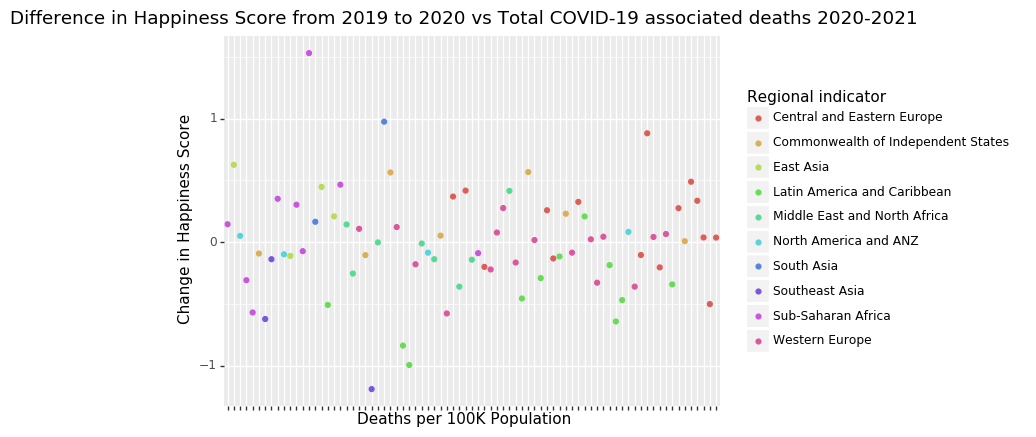

<ggplot: (308428369)>

In [167]:
#Plot displaying change in happiness score from 2019 to 2020 vs total COVID-19 associated deaths in 2020-2021

p = ggplot(data=delta_2019_to_2020_w_regions) + geom_point(mapping=aes(x='Deaths per 100K Population', y='Life.Ladder', color="Regional indicator"))
p + theme(axis_text_x=element_blank()) + labs(title="Difference in Happiness Score from 2019 to 2020 vs Total COVID-19 associated deaths 2020-2021", y="Change in Happiness Score") 

The graph we have constructed appears to show that  change in cumulative "happiness scores" from 2019 to 2020 appears to be uncorrelated with the amount of deaths per 100,000 people from COVID-19 in the years 2020-2021 (line of fit would run almost parallel to the x-axis).

This goes against the hypothesis we had at the beginning of the data analysis (that the countries hardest hit by COVID-19 would have the largest declines in "happiness score").


**Note:** The data for COVID-19 deaths per 100,000 is accurate up to the present day (that is, it includes deaths from 2020 and half of 2021). It is possible that this may have skewed the above scatter plot, causing to appear as if change in "happiness score" is uncorrelated with COVID-19 mortality. However, since data for solely 2020 deaths is unavailable, we have chosen to operate under the assumption that countries which saw the fiercest outbreaks of COVID-19 in 2020 (and thus, presumably the highest changes in "happiness score") would likely have the highest death tolls up to this point in the present.

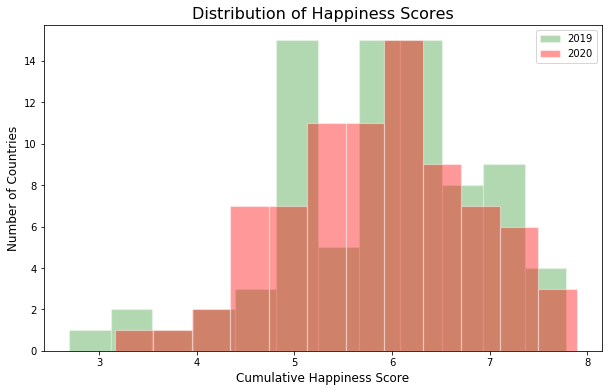

In [158]:
import matplotlib
from matplotlib import pyplot

#Note: Pyplot was used in place of plotnine because plotnine does not allow for graph overlays

#Citation: https://datavizpyr.com/overlapping-histograms-with-matplotlib-in-python/

pyplot.figure(figsize = (10, 6))
num_bins = 12

pyplot.hist(all_2019_data["Life.Ladder"], num_bins, label = '2019', alpha = 0.3, color = 'green', edgecolor='white', linewidth=1.2)
pyplot.hist(all_2020_data["Life.Ladder"], num_bins, label = '2020', alpha = 0.4, color = 'red', edgecolor='white', linewidth=1.2)




pyplot.title("Distribution of Happiness Scores", size = 16)

pyplot.xlabel("Cumulative Happiness Score",size=12)
pyplot.ylabel("Number of Countries",size=12)
pyplot.legend(loc='upper right')



Per the plot shown above, we cannot conclusively determine that "happiness scores" declined for most countries from 2019 to 2020. 

Therefore, I have decided to include a second histogram which plots the change in "happiness score" from 2019 to 2020 to determine whether a majority of the countries had a negative quantity for this.

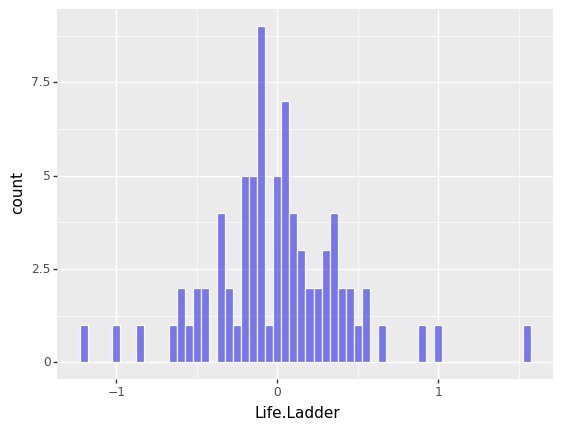

<ggplot: (307361097)>

In [166]:
ggplot(delta_2019_to_2020_w_regions, aes(x='Life.Ladder'))+ geom_histogram(binwidth=0.05, alpha=0.5, color = 'white', fill = 'blue')

As per the plot, it appears there are slightly more countries that experienced a decline in "happiness score" from 2019 to 2020 than countries that did not. 

This is in line with our expectation that cumulative “happiness scores” would decline for most countries from 2019 to 2020. However, it doesn't appear that this shift was the result of COVID-19 when we account for this plot as well as the scatter plot of change in "happiness score" vs COVID-19 related deaths per 100,000.

**This begs the question: Which of the variables included in the dataset account for changes in "happiness score" between countries?**